# 数据格式化

在实际使用中，图片往往很多，移动处理很不方便，我们就使用tensorflow支持的一种文件格式，对图片进行处理，方便后期的使用，文件格式为.tfrecord，将图片和标签转化为二进制文件，在使用的时候再对数据进行读取，然后进行下一步的操作。

## 为啥我不用官方的例子还要自己写？
## 加深印象！！

In [1]:
import tensorflow as tf

In [2]:
root_path = './flowers/'
labels_list= [x for x in range(17)]
print(labels_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [4]:
import os
path_list = os.listdir(root_path + '0')
image_path = root_path + '0/' + path_list[0]
all_image_paths = [root_path + '0/' + x for x in path_list]
f = open('images.txt', 'a')
for i in all_image_paths:
    f.write(i + '\n')
    
f.close()

# images_len = len(all_image_paths)
# # print(all_image_paths)


# img_raw = tf.io.read_file(image_path)
# img_tensor = tf.image.decode_image(img_raw)


# # print(img_tensor)
# image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
# print(image_ds)

In [23]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [227, 227])
    image = tf.expand_dims(image, axis=0)
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

<MapDataset shapes: (1, 227, 227, 3), types: tf.float32>
(227, 227, 3)


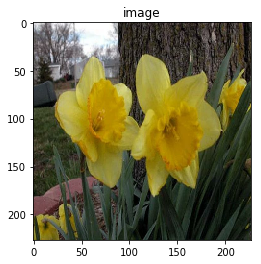

In [25]:
image_ds = image_ds.map(load_and_preprocess_image)
print(image_ds)

import matplotlib.pyplot as plt
%matplotlib inline
for i in image_ds:
    print(i[0,:,:,].shape)
    plt.figure("Image") # 图像窗口名称
    plt.imshow(i[0,:,:,])
    plt.axis('on') # 关掉坐标轴为 off
    plt.title('image') # 图像题目
    plt.show()
    break


In [66]:
labels_ds = tf.data.Dataset.from_tensor_slices([x-x for x in range(images_len)])
print(labels_ds)
print(image_ds)

<TensorSliceDataset shapes: (), types: tf.int32>
<MapDataset shapes: (1, 227, 227, 3), types: tf.float32>


In [68]:
data =  tf.data.Dataset.zip((image_ds, labels_ds))

<PrefetchDataset shapes: ((1, 227, 227, 3), ()), types: (tf.float32, tf.int32)>


In [69]:
227# 建立模型
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [70]:
# 进行编译和训练
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(data, epochs=10)

Epoch 1/10
80/80 [==============================] - 15s 187ms/step - loss: 0.0369 - accuracy: 0.9875
Epoch 2/10
80/80 [==============================] - 14s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/10
14/80 [====>.........................] - ETA: 13s - loss: 0.0000e+00 - accuracy: 1.0000

KeyboardInterrupt: 

In [38]:
ds = tf.data.Dataset.from_tensor_slices(data)

# # 元组被解压缩到映射函数的位置参数中
# def load_and_preprocess_from_path_label(path, label):
#     return load_and_preprocess_image(path), label

# image_label_ds = ds.map(load_and_preprocess_from_path_label)
# image_label_ds

ValueError: Unbatching a dataset is only supported for rank >= 1

## 写入tfrecord

In [97]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.io.read_file)


# labels_ds =  tf.data.Dataset.from_tensor_slices([0, 1])
# dataset = tf.data.Dataset.from_tensor_slices((image_ds,labels_ds))
# # tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
# # tfrec.write(image_ds)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 读取tfrecord

In [102]:
import numpy as np


raw_image_dataset = tf.data.TFRecordDataset('images.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
    # 'height': tf.io.FixedLenFeature([], tf.int64),
    # 'width': tf.io.FixedLenFeature([], tf.int64),
    # 'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto,
                                      {'image_raw': tf.io.FixedLenFeature([], tf.string)})['image_raw']


def _labels(example_proto):
    return tf.io.parse_single_example(example_proto,
                                      {'label': tf.io.FixedLenFeature([], tf.int64)})['label']


# def _images(example):
#     image = tf.image.decode_jpeg(example, channels=3)
#     image = tf.image.resize(image, [227, 227]) / 225.0
#     return image

In [112]:
images = raw_image_dataset.map(_parse_image_function)
labels = raw_image_dataset.map(_labels)
images = images.map(load_and_preprocess_image)

dataset = tf.data.Dataset.zip((images, labels))
print(dataset)

ds = dataset.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=2))




<ZipDataset shapes: ((227, 227, 3), ()), types: (tf.float32, tf.int64)>
<_ShuffleAndRepeatDataset shapes: ((227, 227, 3), ()), types: (tf.float32, tf.int64)>


In [117]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.Dense())